# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression
## **Part b)** - Feed-Forward Neural Network

#### Program imports and defaults

In [30]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

#### Dataset setup

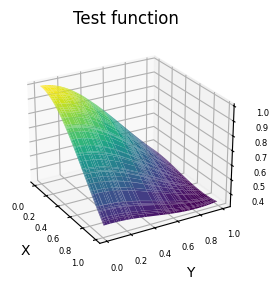

In [31]:
anp.random.seed(def_seed)
cases = ['1D','2D','Franke']
case_ = cases[1]
show = True #True False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                            # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
if case_ == '1D':
    f = dataset.plot(labels=['Test function','x','y','dataset','true'])
else:
    f = dataset.plot(labels=['Test function','X','Y','Z'])

### Feed-Forward Neural Network analysis
#### Training network with fixed parameters $\eta, \gamma, \lambda$
Simple training of the network with fixed parameters for the learning rate $\eta$, regularization, $\lambda$, gradient momentum, $\gamma$, as well as a fixed number of mini-batches and epochs.

Method: MomentumGD
Regularization, λ: 0.0001
Learning rate,  η: 0.001
MSE:  0.009560575671501498


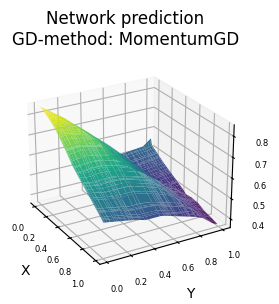

In [32]:
anp.random.seed(def_seed)

if case_ == '1D':
    target = dataset.target[0]
    input = dataset.x

else:
    target = dataset.target_f
    x = dataset.xf; y = dataset.yf
    input = anp.zeros((x.shape[0],2))
    input[:,0] = x[:,0]
    input[:,1] = y[:,0] 

n_inputs,n_features = input.shape

layer_output_sizes = [5,100,5,1]

hidden_func  = ReLU #sigmoid ReLU, expReLU, LeakyReLU,identity
hidden_der = elementwise_grad(hidden_func,0)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(identity); 
output_der = elementwise_grad(act_funcs[-1],0); act_ders.append(output_der)

cost_func = mse_predict
cost_der   = grad(cost_func,0)

network = FFNeuralNework(network_input_size=n_features,layer_output_size=layer_output_sizes,
                         activation_functions=act_funcs,activation_derivatives=act_ders,
                         cost_function=cost_func,cost_derivative=cost_der)
network.reset()
network.create_layers()

## Gradient Descent setup
eta = 0.001
gamma = 0.00000001
lmbda = 0.0001; lp = 2
batches = 30; epoch = 200
decay_rms = 0.9
adagrad_mom = 0.00000000001
ADAM_decay = [0.9, 0.99]

## Calling the gradient descent (GD)-method
#GDMethod = [PlainGD(eta,lmbda=lmbda,lp=lp),PlainGD(eta,lmbda=lmbda,lp=lp)]
GDMethod = [MomentumGD(eta,gamma,lmbda=lmbda,lp=lp),MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)]
#GDMethod = [Adagrad(eta,adagrad_mom,lmbda=lmbda,lp=lp),Adagrad(eta,adagrad_mom,lmbda=lmbda,lp=lp)] 
#GDMethod = [RMSprop(eta,decay=decay_rms),RMSprop(eta,decay_rms)] 
#GDMethod = [ADAM(eta,ADAM_decay),ADAM(eta,ADAM_decay)] 

network.train_network(input,target,GDMethod,batches=batches,epochs=epoch)

final_predict = network.feed_forward(input)

if show == True:
    print(f'Method: {GDMethod[0].__class__.__name__}')
    print('Regularization, λ:',lmbda)
    print('Learning rate,  η:',eta)
    print('MSE: ',mse_predict(final_predict,target))

if case_ == '1D':
    plot1D(input,[target,final_predict],
           labels=[f'Network prediction\nGD-method: {GDMethod[0].__class__.__name__}, {hidden_func.__class__.__name__}'
                                                ,'x','y','f (x)','ỹ (x)','',''])
else:
    final_fit = final_predict.reshape(Nx,Ny)
    plot2D(dataset.xx,dataset.yy,final_fit,
           labels=[f'Network prediction\nGD-method: {GDMethod[0].__class__.__name__}'
                                                   ,'X','Y','Z'])

#### Study of regularization, $\lambda$ vs. learning rate, $\eta$
Keeping the gradient descent momentum, $\gamma$, number of mini-batches and epochs fixed, this shows the training of the network with different values for the learning rate, $\eta$, and regularization term, $\lambda$. The `PlainGD`-method is a regularized stochastic gradient descent method if $\lambda = 0$, where the regularization order is set with the `lp`-keyword. The same holds for the `MomentumGD`-method.

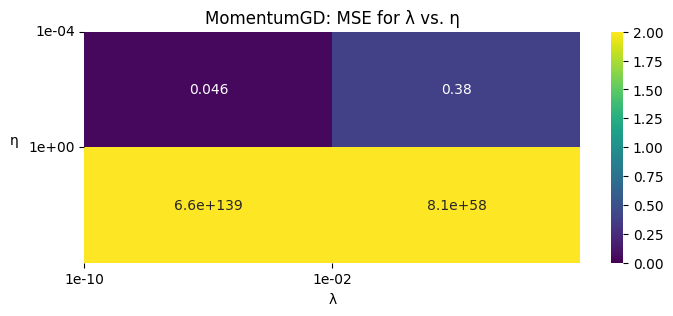

In [33]:
anp.random.seed(def_seed)

## Resetting some instance variables of the network before next run
network.reset()

## 
show = False

## SDG-parameters
num_param = 2
eta = anp.logspace(-4,0,num_param)
lmbda = anp.logspace(-10,-2,num_param)
gamma = 0.00001; lp = 2
adagrad_gamma = gamma

MSE_NN = anp.zeros((len(eta),len(lmbda)))
for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Recreating the layers
        network.create_layers()

        ## Calling GDMethod with new parameters
        #GDMethod = [PlainGD(eta[i],lmbda=lmbda[j],lp=lp),PlainGD(eta[i],lmbda=lmbda[j],lp=lp)]
        GDMethod = [MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp),MomentumGD(eta[i],gamma,lmbda=lmbda[j],lp=lp)]
        #GDMethod = [Adagrad(eta[i],adagrad_mom,lmbda=lmbda,lp=lp),Adagrad(eta[i],adagrad_mom,lmbda=lmbda,lp=lp)] #

        network.train_network(input,target,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(input)
        
        MSE_NN[i,j] = mse_predict(final_predict,target)
        if show == True:
            print(f'Method: {GDMethod[0].__class__.__name__}')
            print('Regularization, λ:',lmbda[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,target))

    network.reset()

#MSE_NN = anp.nan_to_num(MSE_NN,nan=1)

fig,ax = lambda_eta(MSE_NN,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
_ = ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for λ vs. η')#\nγ = %.0e'%(gamma))

#### Study of momentum, $\gamma$ vs. learning rate, $\eta$
Keeping the regularization parameter, $\lambda$, number of mini-batches and epochs fixed, this studies how the different values of learning rate, $\eta$, and gradient descent momentum, $\gamma$, affects the network training. The `PlainGD`-method is a regularized stochastic gradient descent method if $\lambda = 0$, where the regularization order is set with the `lp`-keyword. The same holds for the `MomentumGD`-method.

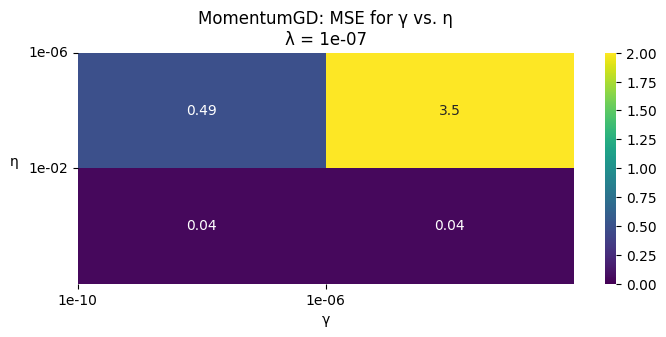

In [34]:
anp.random.seed(def_seed)

network.reset()

#num_param = 4
eta = anp.logspace(-6,-2,num_param)
gamma = anp.logspace(-10,-6,num_param)
lmbda = 1e-7; lp = 2
#batches = 40; epoch = 100

MSE_NN = anp.zeros((len(eta),len(gamma)))
for i in range(len(eta)):
    for j in range(len(gamma)):
        network.create_layers()
        #GDMethod = [PlainGD(eta[i],lmbda=lmbda[j]),PlainGD(eta[i],lmbda=lmbda[j])]
        GDMethod = [MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp),MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp)]
        #GDMethod = [Adagrad(eta,adagrad_mom),Adagrad(eta,adagrad_mom)] #
        #GDMethod = [RMSprop(eta,decay=decay_rms),RMSprop(eta,decay_rms)] #
        #GDMethod = [ADAM(eta,ADAM_decay),ADAM(eta,ADAM_decay)] #

        network.train_network(input,target,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(input)
        
        MSE_NN[i,j] = mse_predict(final_predict,target)
        if show == True:
            print(f'Method: {GDMethod[0].__class__.__name__}')
            print('Momentum,       γ:',gamma[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,target))

    network.reset()

fig,ax = lambda_eta(MSE_NN,[gamma,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in gamma],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for γ vs. η\nλ = %.0e'%(lmbda))
_ = ax.set_xlabel('γ')

#### Study of Adagrad momentum, $\gamma_{\text{adagrad}}$, and regularization, $\lambda$

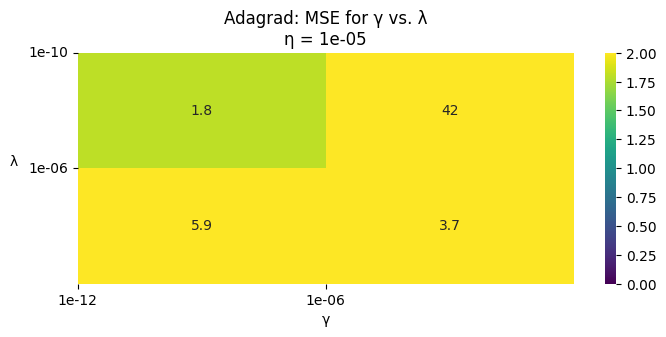

In [35]:
anp.random.seed(def_seed)

network.reset()

#num_param = 4
eta = 1e-5
adagrad_gamma = anp.logspace(-12,-6,num_param)
lmbda = anp.logspace(-10,-6,num_param)
lp = 2
#batches = 40; epoch = 100

MSE_NN = anp.zeros((len(lmbda),len(adagrad_gamma)))
for i in range(len(lmbda)):
    for j in range(len(adagrad_gamma)):
        network.create_layers()

        GDMethod = [Adagrad(eta,adagrad_gamma[j],lmbda=lmbda[i],lp=lp),Adagrad(eta,adagrad_gamma[j],lmbda=lmbda[i],lp=lp)]

        network.train_network(input,target,GDMethod,batches=batches,epochs=epoch)

        final_predict = network.feed_forward(input)
        
        MSE_NN[i,j] = mse_predict(final_predict,target)
        if show == True:
            print(f'Method: {GDMethod[0].__class__.__name__}')
            print('Momentum,       γ:',gamma[j])
            print('Learning rate,  η:',eta[i])
            print('MSE: ',mse_predict(final_predict,target))

    network.reset()

fig,ax = lambda_eta(MSE_NN,[adagrad_gamma,lmbda],
                    axis_tick_labels=[[f'{y:.0e}' for y in adagrad_gamma],[f'{y:.0e}' for y in lmbda]],
                    cbar_lim=[0.,2.]
                    )
ax.set_title(f'{GDMethod[0].__class__.__name__}: MSE for γ vs. λ\nη = %.0e'%(eta))
_ = ax.set_xlabel('γ'); _ = ax.set_ylabel('λ')

### Comparison with Scikit-Learn's Neural network implementation

/home/anders_tb/02-uio/fysstk4155/project-2-fys-stk4155/p2-venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.029635181911329855
0.01957605982783459
0.01957605982783459


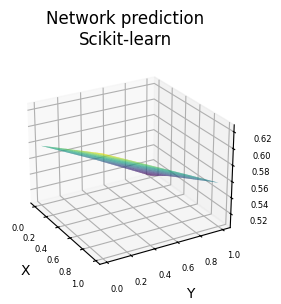

In [38]:
from sklearn.neural_network import MLPRegressor
lmbda = 1e-4; gamma = 1e-3
sklearn_network = MLPRegressor(layer_output_sizes,activation='relu',solver='adam',#,batch_size=5,
                               max_iter=1000,warm_start=True,alpha=lmbda,
                               learning_rate_init=eta,
                               random_state=def_seed,momentum=gamma
                               )

sklearn_network.fit(input,target)
final_pred = sklearn_network.predict(input)
print(sklearn_network.score(input,target))
print(sklearn_network.best_loss_)
print(sklearn_network.loss_)
if case_ == '1D':
    plot1D(input,[target,final_pred],
           labels=[f'Network prediction\nScikit-learn'
                                                ,'x','y','f (x)','ỹ (x)','',''])
else:
    final_pred = final_pred.reshape(Nx,Ny)
    plot2D(dataset.xx,dataset.yy,final_pred,
           labels=[f'Network prediction\nScikit-learn'
                                                   ,'X','Y','Z'])
